In [9]:
import pandas_profiling

import scipy as ss
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK 
from hyperopt.pyll.base import scope
from functools import partial


from sklearn.utils import shuffle

from lightgbm import LGBMRegressor 

from catboost import *

import shap

# Подготовка данных

In [2]:
df = pd.read_csv('C:/Users/nikit/Yandex/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df_test = df.copy()

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Огромное стандартное отклонение у Price, что нехорошо

Выводы по первоначальному осмотру данных: имеем 10772 строчек с 0 в столбце **Price**, 37490 строчек с пропусками в столбце **VehicleType**, 19833 строчек с пропусками в столбце **Gearbox**, 40225 строчек с 0 в столбце **Power**, 19705 строчек с пропусками в столбце **Model**, 37352 строчек с пропусками в столбце **RegistrationMonth**, 32895 строчек с пропусками в столбце **FuelType**, 71154 строчек с пропусками в столбце **NotRepaired**.

### Price - почему 0 значения?

Исходя из первого осмотра данных, видно, что есть 10к строчек, где цена автомобиля 0, почему так вышло? Кто-то просто решил "прикольнуться" и выставить за такую цену? 


**В итоге удалил**

<Figure size 1152x864 with 0 Axes>

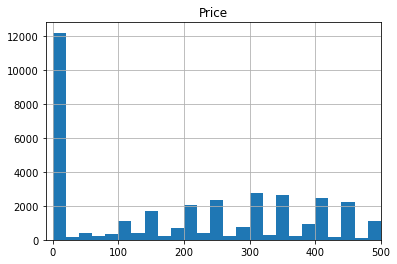

In [9]:
plt.figure(figsize=(16, 12))
df.hist(column='Price', bins=1000);
plt.xlim(-10, 500);

In [10]:
df[df['Price'] == 0].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10


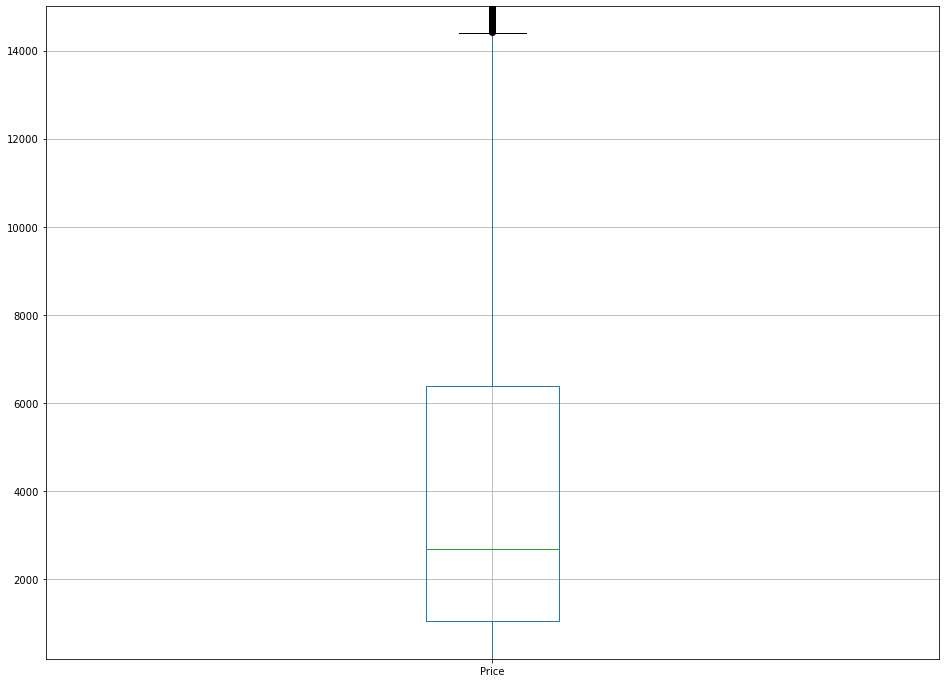

In [11]:
plt.figure(figsize=(16, 12))
df.boxplot(column='Price');
plt.ylim(200, 15000);

In [14]:
# функция для бинаризации годов
def bin_years(df):
    year = df['RegistrationYear']
    if year < 1900:
        return '< 1900'
    elif year >= 1900 and year <= 1930:
        return '1900-1930'
    elif year > 1930 and year <= 1970:
        return '1930-1970'
    elif year > 1970 and year <= 2000:
        return '1970-2000'
    elif year > 2000 and year <= 2010:
        return '2000-2010'
    return '>2010'

In [15]:
df['Years'] = df.apply(bin_years, axis=1)
df_test['Years'] = df_test.apply(bin_years, axis=1)

<AxesSubplot:>

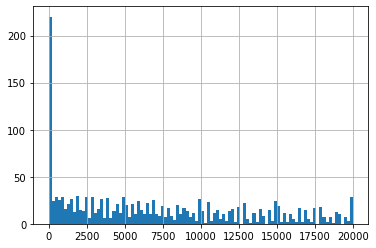

In [16]:
df[(df['Years'] == '1930-1970')]['Price'].hist(bins=100)

<AxesSubplot:>

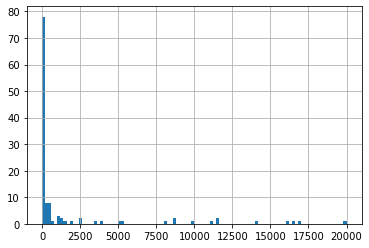

In [17]:
df[(df['Years'] == '1900-1930')]['Price'].hist(bins=100)

<AxesSubplot:>

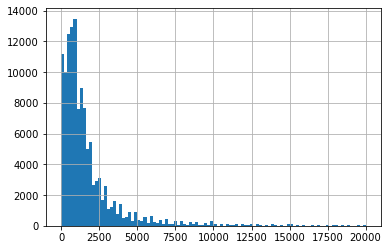

In [18]:
df[(df['Years'] == '1970-2000')]['Price'].hist(bins=100)

In [19]:
df['Years'].value_counts()

2000-2010    178440
1970-2000    125072
>2010         49186
1930-1970      1485
1900-1930       120
< 1900           66
Name: Years, dtype: int64

Раритетные автомобили по ГОСТу делятся на три группы: выпущенные до 1946 года, с 1946 по 1970 и с 1970 года.

**Анализ года и цены**

Какие теоретически могут быть ошибки? Маленькая цена у новых машин, а также маленькая цена у машин до 1970, примерно, года, т.к. такие машины считаются раритетными. Также могут быть машины с огромной ценой 2000-2010 годов, такие, что больше новых машин(но также могут быть тюнингованные, нужно учесть)

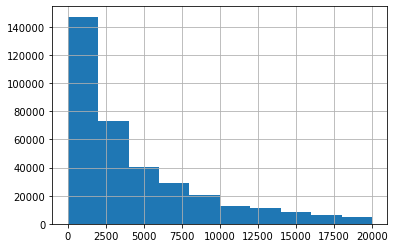

In [22]:
df['Price'].hist();

In [23]:
df['Years'].value_counts()

2000-2010    178440
1970-2000    125072
>2010         49186
1930-1970      1485
1900-1930       120
< 1900           66
Name: Years, dtype: int64

Сколько может стоить раритетная машина, даже не представляю минимальную цену(сделал около 500 евро)

In [24]:
drop_index_one = df_test[((df_test['Years'] == '1900-1930') | (df_test['Years'] == '1930-1970')) & (df_test['Price'] < 500)].index
df_test = df_test.drop(drop_index_one)

Новые машины считаю около 2010+ годов, т.к. дата публикаций равна 2016 году

In [25]:
drop_index_two = df_test[(df_test['Years'] == '>2010') & (df_test['Price'] < 600)].index
df_test = df_test.drop(drop_index_two)

Интересно, есть машины, которые новые и имеют пробег 150к км за 4 месяца, это 1250 км в день, может ли такое быть, не думаю, нужно будет удалить такие машины. За 2 года еще реально по 300км в день, если таксист(предполагаю).

In [26]:
drop_index_three = df_test[(df_test['RegistrationYear'] == 2016) & (df_test['Kilometer'] == 150000)].index
df_test = df_test.drop(drop_index_three)

Машины среднего года, в районе 2000-2010 думаю, что стоят около 400 евро минимум

In [27]:
drop_index_four = df_test[(df_test['Years'] == '2000-2010') & (df_test['Price'] < 400)].index
df_test = df_test.drop(drop_index_four)

### VehicleType - пропущенные значения или нет?

Что можно сказать на счет столбца с типом кузова? Есть пропуски, значительные, 10 процентов от всех данных, но также мы имеем значение **other** среди вссех типов кузова, почему бы нам не заменить пропуски на данное значение? Моделька сама будет решать, что делать с данной группой, с учетом того, что мы будем использовать леса.

In [28]:
df[df['VehicleType'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37490 entries, 0 to 354365
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DateCrawled        37490 non-null  object
 1   Price              37490 non-null  int64 
 2   VehicleType        0 non-null      object
 3   RegistrationYear   37490 non-null  int64 
 4   Gearbox            27520 non-null  object
 5   Power              37490 non-null  int64 
 6   Model              30662 non-null  object
 7   Kilometer          37490 non-null  int64 
 8   RegistrationMonth  37490 non-null  int64 
 9   FuelType           20195 non-null  object
 10  Brand              37490 non-null  object
 11  NotRepaired        16919 non-null  object
 12  DateCreated        37490 non-null  object
 13  NumberOfPictures   37490 non-null  int64 
 14  PostalCode         37490 non-null  int64 
 15  LastSeen           37490 non-null  object
 16  Years              37490 non-null  obje

In [29]:
# заполняю пропуски
df['VehicleType'] = df['VehicleType'].fillna('other')
df_test['VehicleType'] = df_test['VehicleType'].fillna('other')

### Gearbox - пропущенные значения

Имеем 20к строчек с пропуском типа коробки передач. Что можно сделать? Заполнить пропуски unknow

In [30]:
df[df['Gearbox'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Years
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47,1900-1930
16,2016-04-01 12:46:46,300,other,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46,>2010
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43,1970-2000
37,2016-03-28 17:50:15,1500,other,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02,>2010
40,2016-03-26 22:06:17,0,other,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34,1970-2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,2016-03-16 13:36:25,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16 00:00:00,0,12057,2016-03-17 12:17:07,2000-2010
354305,2016-04-03 13:46:24,3500,other,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03 00:00:00,0,74579,2016-04-05 12:44:38,1970-2000
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30 00:00:00,0,25436,2016-04-07 13:50:41,1970-2000
354338,2016-03-31 19:52:33,180,other,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04,1970-2000


In [31]:
# заполняю пропуски
df_test['Gearbox'] = df_test['Gearbox'].fillna('unknow')

### Power - 0 значения, а таже выбросы

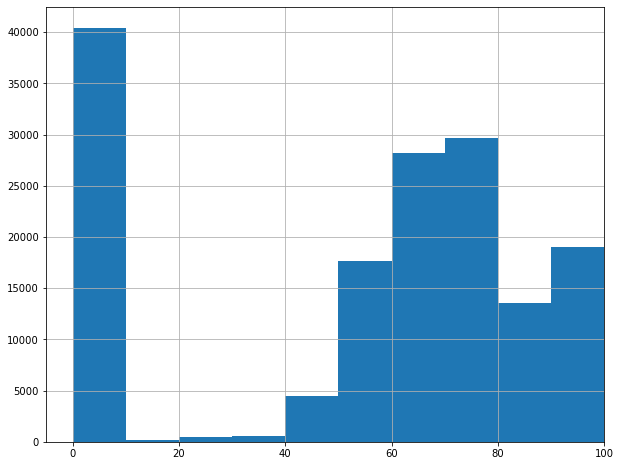

In [32]:
plt.figure(figsize=(10, 8))
df['Power'].hist(bins=2000);
plt.xlim(-5, 100);

Видно много значений(40к), где мощность двигателя равна 0 сил.

Можно верить в то, что двигатели имели мощность в районе 10-20 л.с после 1900 и до 1950, 0 л.с нереально, это выбросы, которые придется удалить, либо же заменить...
После же идут двигатели, которые уж точно выше по мощности 20-30 л.с, следовательно, машины, которые имеют регистрацию выше 1950 и л.с. меньше 20, считаю, что выбросы.
Можно попробовать заменить для некоторых машин значения 0 на пропуск и постараться с помощью ближайших соседей восстановить мощность, но насколько она будет корректной :)

Есть машины, которые просток купили и ездили, а есть те, которые ещё тюнинговали, как я понимаю. Ставили новый двигатель, либо делали "стейдж", т.к. у машин 2005, допустим, годов л.с. 500+


**Что планирую делать?**, либо же я удаляю машины, у которых больше 400-450 сил, в районе 800 строк, либо же удаляю те, которые больше 1000 л.с., а больше 400-450 маркирую, что это "необычные" машины в явном виде. На счет машин, которые имеют 100 л.с. и тюнинг не говорится, их никак не выявить.

In [33]:
mask =((df_test['Power'] <= 20) & (df_test['Power'] >= 10) & (df['RegistrationYear'] >= 1900) & (df['RegistrationYear'] < 1950)) | \
((df_test['Power'] > 20) & (df['RegistrationYear'] >= 1950)) & (df_test['Power'] < 450)
df_drop_power = df_test[~mask].index

In [34]:
df_test = df_test.drop(df_drop_power)

(200.0, 1000.0)

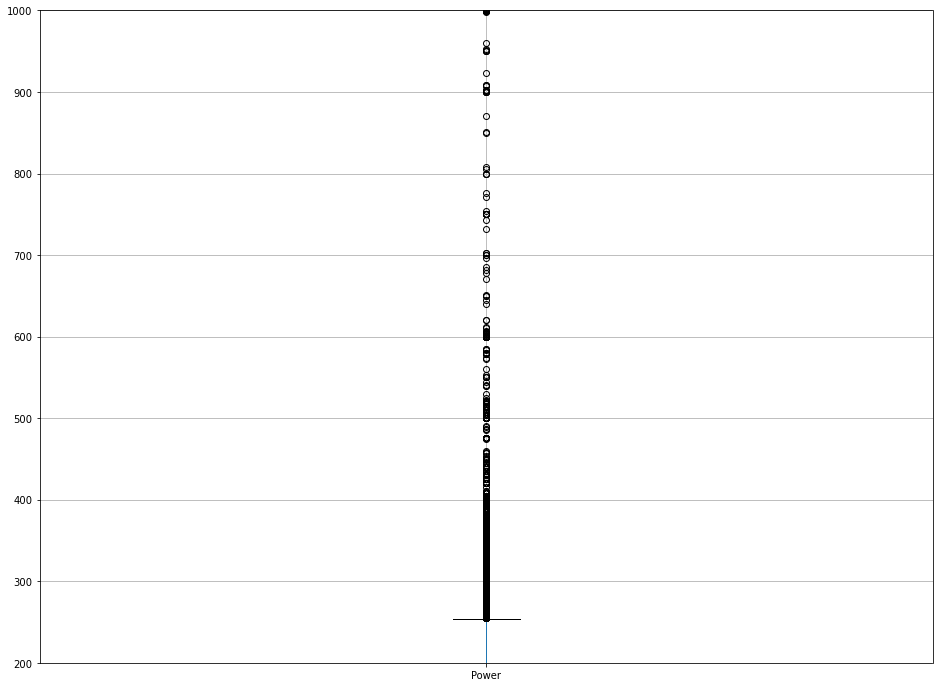

In [35]:
plt.figure(figsize=(16, 12))
df.boxplot(column='Power');
plt.ylim(200, 1000)

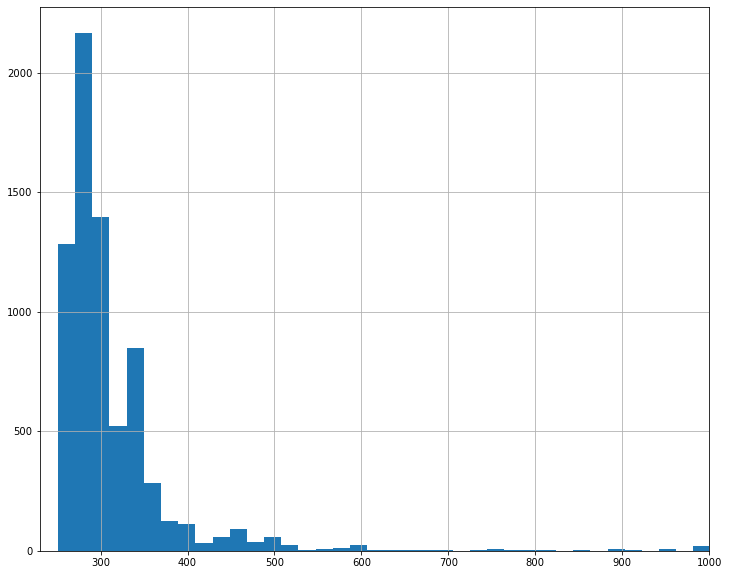

In [36]:
plt.figure(figsize=(12, 10))
df[df['Power'] > 250]['Power'].hist(bins=1000);
plt.xlim(230, 1000);

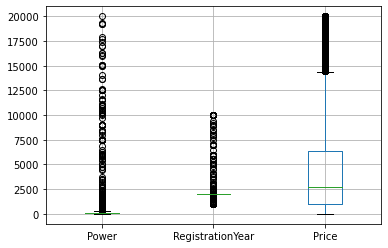

In [37]:
df.boxplot(column=['Power', 'RegistrationYear', 'Price']);

### RegistrationYear - жеские выбросы

29 января 1886 года Карл Фридрих Бенц (Karl Friedrich Benz) представил миру свой первый автомобиль.

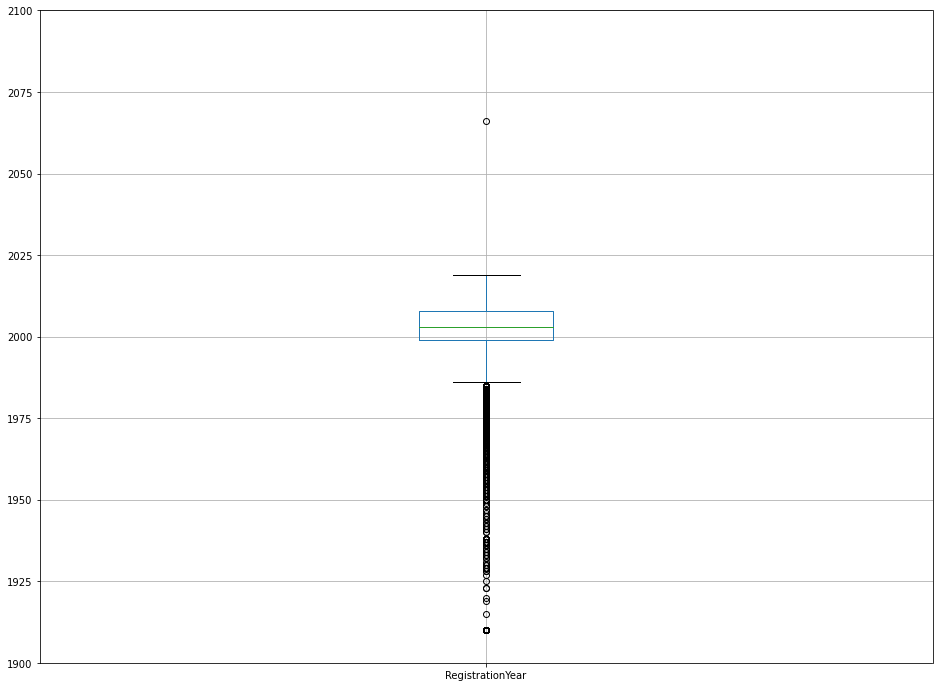

In [38]:
plt.figure(figsize=(16, 12))
df.boxplot(column='RegistrationYear');
plt.ylim(1900, 2100);

Если посмотреть по диаграмме размаха, то можно сказать, что выбросы имеются. Я считаю, что выбросы по нижней границе в районе 1900 годов, т.к. первая машина появилась в 1886, также отбор будет таким: имеем машину с годом 1900-1930 и л.с. до 40, тогда будем считать машину реальной, также 1930+ года и 40+ л.с. тоже будем считать реальной, а также машины от 10 л.с.,, а за 2000 года уже обычные машины, которые ездят по сей день, т.е. около 80+ л.с. Все, что выше 2022 и ниже 1900 - также выбросы

In [39]:
# удаляю выбросы
index_drop_years = df_test[(df_test['RegistrationYear'] < 1900) | (df_test['RegistrationYear'] > 2022)].index

In [40]:
df_test = df_test.drop(index_drop_years)

In [41]:
df[(df['RegistrationYear'] < 1930) & (df['RegistrationYear'] > 1900) & (df['Power'] > 40)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Years
23750,2016-03-16 19:58:34,3900,wagon,1910,manual,90,passat,150000,0,petrol,volkswagen,NaN,2016-03-16 00:00:00,0,88662,2016-04-07 05:45:53,1900-1930
62803,2016-03-07 22:58:46,3400,small,1910,manual,90,beetle,90000,4,NaN,volkswagen,no,2016-03-07 00:00:00,0,34308,2016-03-12 08:16:51,1900-1930
74814,2016-03-21 12:52:05,400,other,1910,NaN,60,golf,150000,0,petrol,volkswagen,NaN,2016-03-21 00:00:00,0,29462,2016-03-25 09:17:54,1900-1930
93104,2016-04-04 15:25:17,0,sedan,1910,manual,240,NaN,5000,0,petrol,alfa_romeo,yes,2016-04-04 00:00:00,0,61381,2016-04-05 12:19:28,1900-1930
203230,2016-04-01 15:37:14,400,other,1910,manual,170,3er,5000,0,NaN,bmw,NaN,2016-04-01 00:00:00,0,66333,2016-04-03 11:48:08,1900-1930
223945,2016-03-20 07:37:16,1500,bus,1910,manual,999,espace,150000,0,NaN,renault,NaN,2016-03-20 00:00:00,0,24873,2016-04-06 04:45:40,1900-1930
279596,2016-03-24 20:52:53,2500,other,1910,NaN,60,NaN,5000,0,petrol,peugeot,NaN,2016-03-24 00:00:00,0,1279,2016-04-05 13:47:07,1900-1930
302641,2016-04-03 19:47:42,0,other,1910,manual,170,omega,150000,1,NaN,opel,no,2016-04-03 00:00:00,0,32425,2016-04-05 20:44:38,1900-1930
321782,2016-03-25 18:50:51,0,small,1910,manual,600,NaN,150000,5,NaN,volkswagen,yes,2016-03-25 00:00:00,0,35764,2016-03-25 21:27:15,1900-1930


In [42]:
df[(df['RegistrationYear'] > 1930) & (df['RegistrationYear'] < 2000) & (df['Power'] < 10)]['Power'].value_counts()

0    14242
5       19
1       12
4       10
6        5
9        4
3        4
7        2
2        2
8        1
Name: Power, dtype: int64

**Что же делать с выбросами?** 
Либо удалить, либо сделать фичу, которая будет ставить флажок тем строчкам, в которых есть выбросы

**Выбросы №2** - объявления у нас максимум до 2016 года 4 месяца, все машины, которые зарегистрированы выше данных чисел - будущее :) Это выбросы, от которых нужно избавляться.

In [43]:
# удаляю выбросы
index_drop_future = df_test[((df_test['RegistrationYear'] == 2016) & (df_test['RegistrationMonth'] > 4))  
                            | (df_test['RegistrationYear'] > 2016)].index
df_test = df_test.drop(index_drop_future)

### NotRepaired, Model, FuelType - пропущенные значения

В данных столбцах я просто заменю пропуски на unknow, либо UNK

In [44]:
# заменяю пропущенные значения
df_test['NotRepaired'] = df_test['NotRepaired'].fillna('UNK')
df_test['Model'] = df_test['Model'].fillna('UNK')
df_test['FuelType'] = df_test['FuelType'].fillna('UNK')

In [45]:
df['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

### RegistrationMonth - 13 месяцев

Оказывается, что в данных 13 месяцев, вместо 12 :) Предполагаю, что 0 - такая же ошибка, как и в других столбцах, также в строчках, где месяц = 0, больше выбросов, чем в других.

Также хочу подметить, что данные оставляю вместе с 2022 годов, следовательно, те строчки, которые имеют год регистрации 2022 и месяц выше 5 - выбросы(если же они имеются). Также считаю, что у машин 2022 года должен быть пробег не больше 15-20к(если же они есть)

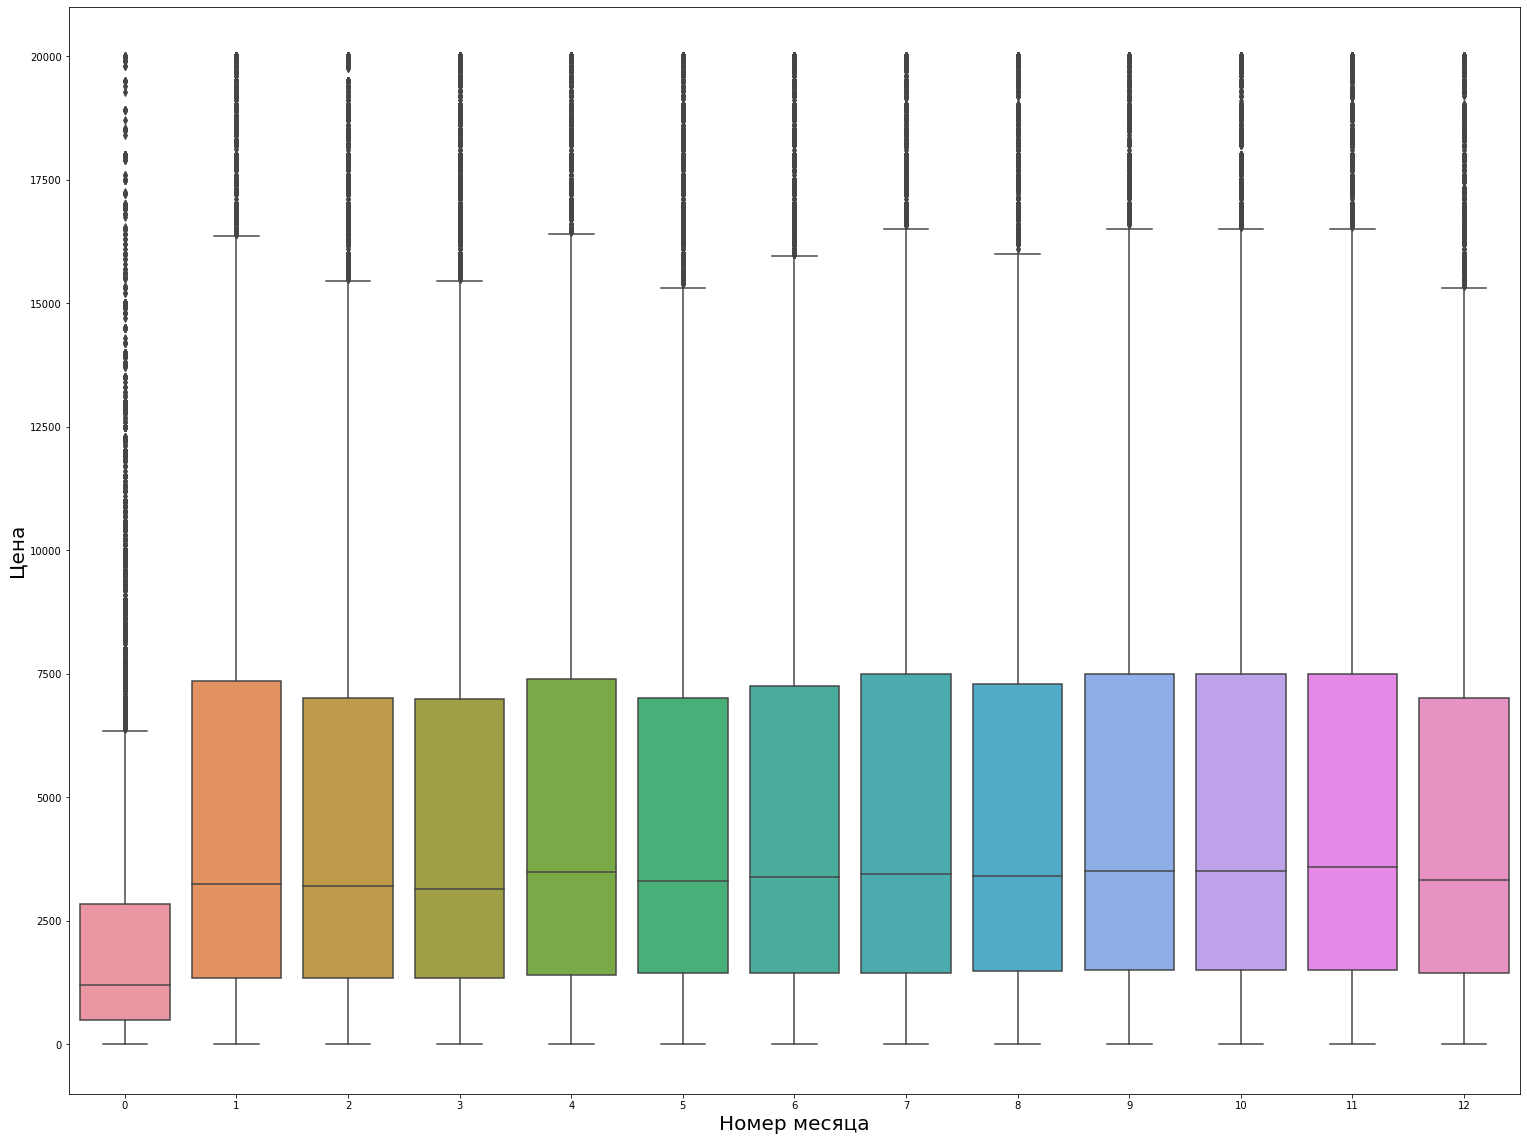

In [46]:
plt.figure(figsize=(26, 20))
sns.boxplot(x=df_test['RegistrationMonth'], y=df_test['Price']);
plt.xlabel('Номер месяца', fontsize=20);
plt.ylabel('Цена', fontsize=20);

In [47]:
# удаляю строки со значением 0 в месяце
index_drop_month = df_test[df_test['RegistrationMonth'] == 0].index
df_test = df_test.drop(index_drop_month)

**Вывод**: Что по предобработке, удалил в районе 20% строчек - выбросов(по моему мнению), а также создал некоторые новые столбцы, которые могут помочь в дальнейшем.

Данных у нас достаточно, чтобы я мог так удалять строчки

### Визуализация данных + более глубокий анализ

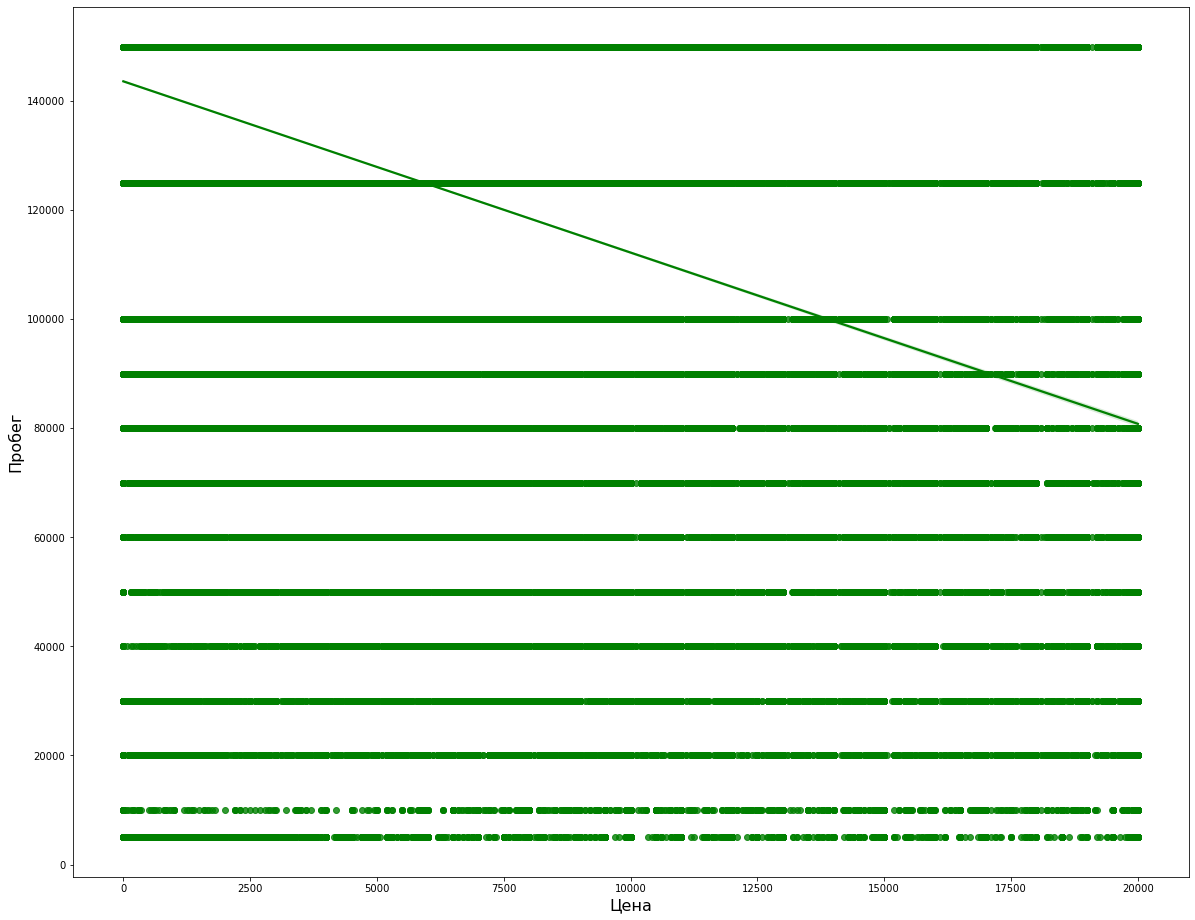

In [49]:
plt.figure(figsize=(20, 16))
sns.regplot(x=df_test['Price'], y=df_test['Kilometer'], color='green');
plt.xlabel('Цена', fontsize=16);
plt.ylabel('Пробег', fontsize=16);

Видно, что есть некая зависимость, что при меньшем количестве пробега цена выше. Чем выше пробег, тем цена ниже, все верно

Здесь же ситуация намного лучше, есть некая зависимость, что уже хорошо :) Можно подумать, что есть выбросы...(те, которые в 1960-1980 годах), но также не забываю, что есть раритетные автомобили, которые имеют ценность. На счет недорогих машин 2000х годов, нужно проверить, я предполагаю, что это разбитые машины.

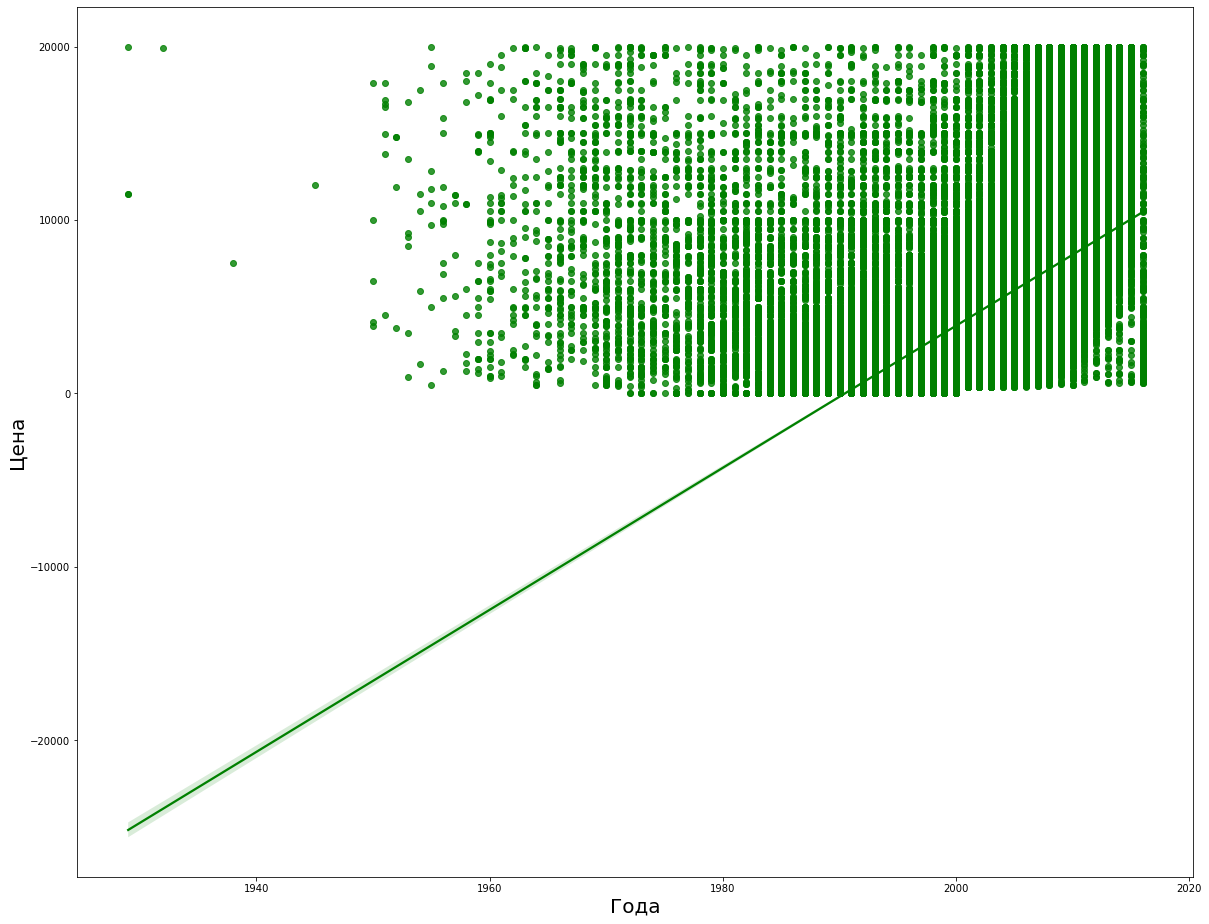

In [51]:
plt.figure(figsize=(20, 16))
sns.regplot(x=df_test['RegistrationYear'], y=df_test['Price'], color='green');
plt.xlabel('Года', fontsize=20);
plt.ylabel('Цена', fontsize=20);

Зависимость такая, как должна быть, чем новее авто, тем оно дороже, но в любом случае, есть машины, которые слегка портят все.

In [52]:
# просматриваю насколько много починенных машин
df_test[(df_test['Price'] < 5000) & (df_test['Years'] == '>2010')]['NotRepaired'].value_counts(), \
df_test[(df_test['Price'] < 5000) & (df_test['Years'] == '>2010')]['Gearbox'].value_counts()
# хочу узнать тип коробки передач, т.к. механика стоит меньше 

(no     622
 yes    203
 UNK    113
 Name: NotRepaired, dtype: int64,
 manual    815
 auto       96
 unknow     27
 Name: Gearbox, dtype: int64)

In [53]:
df_test[(df_test['Price'] < 1000) & (df_test['Years'] == '>2010') & ~(df_test['NotRepaired'] == 'yes')]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Years
4422,2016-03-09 13:55:02,888,other,2016,manual,54,lupo,100000,2,petrol,volkswagen,no,2016-03-09 00:00:00,0,90459,2016-03-11 08:44:44,>2010
8434,2016-03-05 14:27:27,650,other,2016,manual,99,almera,125000,3,petrol,nissan,UNK,2016-03-05 00:00:00,0,56307,2016-04-06 22:15:40,>2010
8814,2016-03-20 11:44:11,647,convertible,2015,auto,190,a5,30000,5,gasoline,audi,no,2016-03-20 00:00:00,0,33619,2016-03-20 11:44:11,>2010
13614,2016-04-03 07:01:44,800,other,2016,auto,45,UNK,125000,1,UNK,smart,UNK,2016-04-03 00:00:00,0,40629,2016-04-03 08:55:34,>2010
44234,2016-03-28 13:38:42,666,other,2016,manual,75,astra,60000,4,petrol,opel,UNK,2016-03-28 00:00:00,0,87437,2016-03-30 04:15:23,>2010
46473,2016-03-09 20:38:42,700,other,2016,manual,60,2_reihe,125000,4,petrol,peugeot,no,2016-03-09 00:00:00,0,12249,2016-03-10 17:15:37,>2010
55847,2016-04-01 14:55:08,600,wagon,2013,auto,268,other,40000,5,gasoline,mercedes_benz,UNK,2016-04-01 00:00:00,0,56072,2016-04-07 05:46:31,>2010
64182,2016-03-19 18:40:35,999,other,2016,manual,75,twingo,125000,4,petrol,renault,UNK,2016-03-19 00:00:00,0,99189,2016-04-03 04:21:37,>2010
71670,2016-03-14 19:37:37,650,sedan,2015,manual,115,mondeo,150000,7,petrol,ford,no,2016-03-14 00:00:00,0,13355,2016-03-31 11:47:18,>2010
76119,2016-03-18 17:47:55,970,other,2016,manual,60,UNK,125000,3,UNK,citroen,no,2016-03-18 00:00:00,0,30451,2016-03-20 05:45:24,>2010


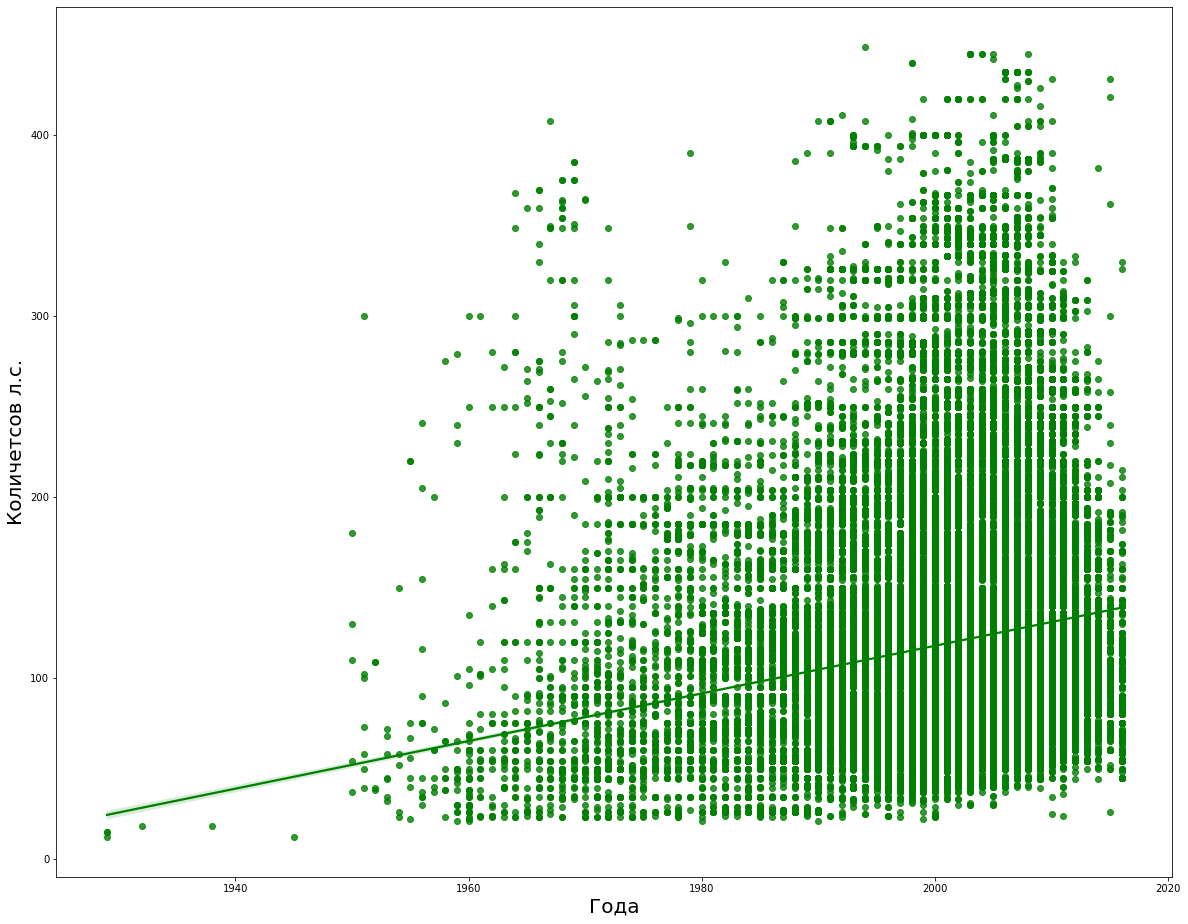

In [55]:
plt.figure(figsize=(20, 16))
sns.regplot(x=df_test['RegistrationYear'], y=df_test['Power'], color='green');
plt.xlabel('Года', fontsize=20);
plt.ylabel('Количетсов л.с.', fontsize=20);

In [56]:
df_test[(df_test['Power'] < 60) & (df_test['Years'] == '>2010')]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Years
52,2016-04-04 10:57:36,1400,other,2016,manual,55,other,5000,1,UNK,hyundai,UNK,2016-04-04 00:00:00,0,34454,2016-04-06 12:45:43,>2010
1490,2016-03-25 16:44:16,6940,small,2012,manual,55,twingo,30000,5,petrol,renault,no,2016-03-25 00:00:00,0,2625,2016-04-06 21:15:24,>2010
4422,2016-03-09 13:55:02,888,other,2016,manual,54,lupo,100000,2,petrol,volkswagen,no,2016-03-09 00:00:00,0,90459,2016-03-11 08:44:44,>2010
6330,2016-03-18 23:37:35,6999,small,2011,auto,54,fortwo,80000,11,gasoline,smart,no,2016-03-18 00:00:00,0,22117,2016-04-06 03:45:08,>2010
6764,2016-03-26 12:55:03,15500,small,2014,auto,58,other,30000,4,electric,renault,no,2016-03-26 00:00:00,0,85088,2016-04-06 00:45:02,>2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338007,2016-03-31 16:55:44,11111,convertible,2013,auto,54,fortwo,40000,6,gasoline,smart,no,2016-03-31 00:00:00,0,72202,2016-04-06 10:46:12,>2010
344321,2016-03-05 14:21:30,990,other,2016,manual,54,golf,100000,3,petrol,volkswagen,UNK,2016-03-04 00:00:00,0,57234,2016-03-06 04:31:34,>2010
346039,2016-03-21 11:45:00,2800,other,2011,manual,55,other,150000,3,gasoline,fiat,UNK,2016-03-21 00:00:00,0,95028,2016-04-02 07:44:44,>2010
348388,2016-04-01 13:25:18,5999,small,2012,manual,55,corsa,150000,12,gasoline,opel,no,2016-04-01 00:00:00,0,65201,2016-04-02 22:29:50,>2010


Запоминаю, что это могут быть выбросы, оставлю их пока что, при подготовке датафреймов потом гляну, что с ними делать

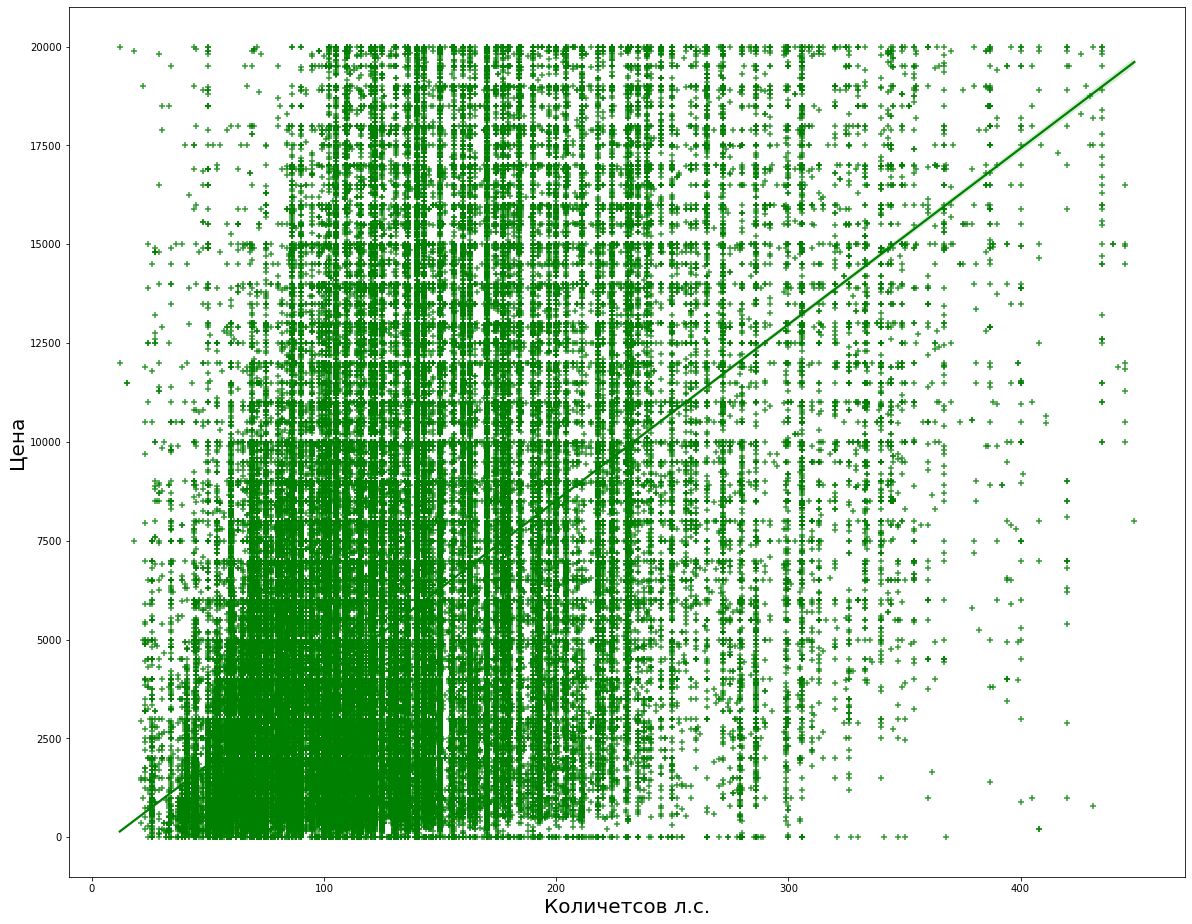

In [58]:
plt.figure(figsize=(20, 16))
sns.regplot(x=df_test['Power'], y=df_test['Price'], color='green', marker="+");
plt.xlabel('Количетсов л.с.', fontsize=20);
plt.ylabel('Цена', fontsize=20);

Раритетные машины, как я понимаю, делают здесь выбросы, но они есть, с ними ничего не поделаешь. Ещё смущает, что  цена максимум 20000 евро, очень странно. Синтетические данные будто

In [59]:
df_test.groupby('Gearbox')['Price'].mean()

Gearbox
auto      7363.173120
manual    4439.143687
unknow    3381.235196
Name: Price, dtype: float64

Да, цены сходятся с тем, что на самом деле, механика ценится меньше, чем автомат.

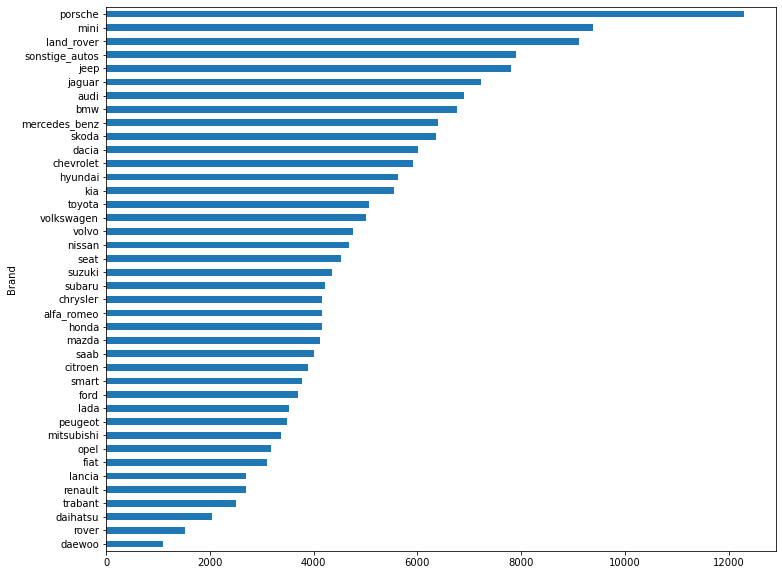

In [60]:
plt.figure(figsize=(12, 10))
df_test.groupby('Brand')['Price'].mean().sort_values().plot.barh();

Да, премиальные авто стоят больше, чем более доступные марки автомобилей.

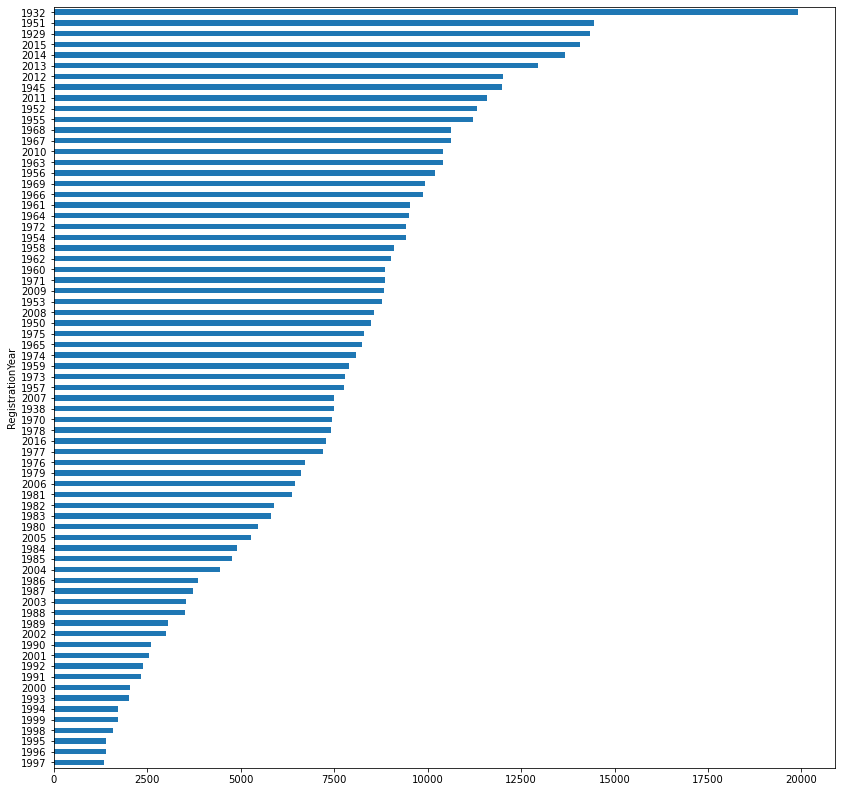

In [61]:
plt.figure(figsize=(14, 14))
df_test.groupby('RegistrationYear')['Price'].mean().sort_values().plot.barh();

Сразу выделяются автомобили, которые, как я считаю, раритетные, они и делают данные чуточку шумными будто... Нужно будет перепроверить это график, когда поделю на 2 датафрейма раритетные и обычные автомобили, если же позволит размер выборки

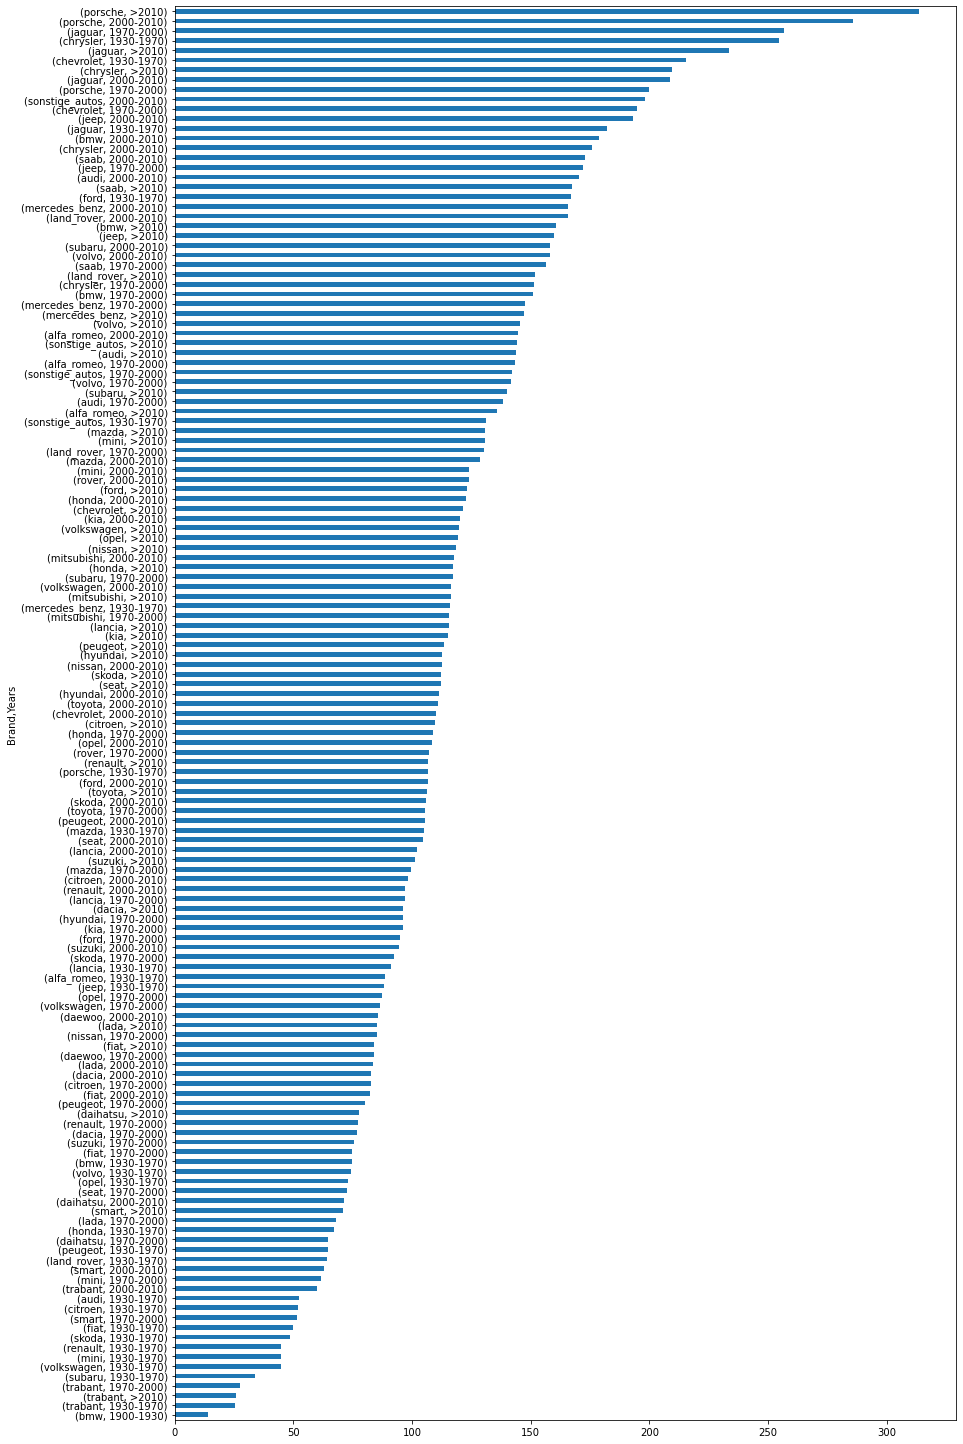

In [62]:
plt.figure(figsize=(14, 26))
df_test.groupby(['Brand', 'Years'])['Power'].mean().sort_values().plot.barh();

Тут какая-то беда, есть машины, которые в 1930-1970 имели больше сил чем те, которые выпускаются в наши дни. Возможно, тюнингованные машины, либо же машины реальные, которые были на те времена самыми быстрыми.

Обновочка: 

Проверил Chrysler, впринципе, машины есть, которые имеют высокие л.с. для тех лет, а если им поставить "чип", либо же модификации, то вполне себе 200+ можно сделать. Я не сильно разбираюсь, но логика моя такова. Спросить мне не у кого, буду верить своему причувствию.

In [63]:
y = df_test.corr().drop(df_test.corr().index[0], axis=1).iloc[0].index
x = df_test.corr().drop(df_test.corr().index[0], axis=1).iloc[0]

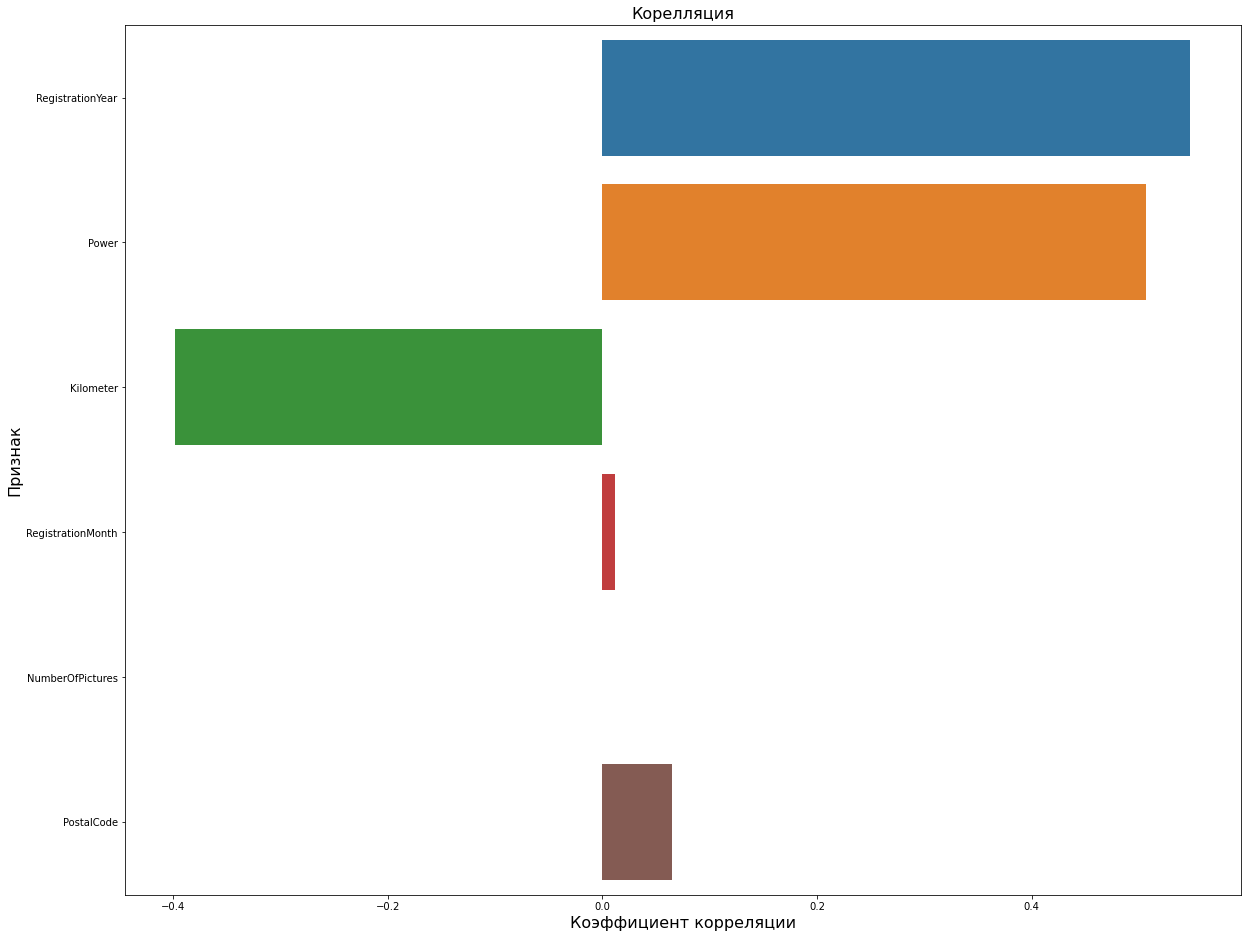

In [64]:
# график корреляции, price_years коррелирует, т.к. состоит из price
plt.figure(figsize=(20, 16))
sns.barplot(x=x, y=y);
plt.xlabel('Коэффициент корреляции', fontsize=16);
plt.ylabel('Признак', fontsize=16);
plt.title('Корелляция', fontsize=16);

In [65]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [66]:
df_test.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,275123.000000,275123.000000,275123.000000,275123.000000,275123.000000,275123.0,275123.000000
mean,5019.028900,2002.708996,121.404408,127864.209826,6.376272,0.0,51377.899023
std,4659.775045,6.231586,52.994419,36766.771311,3.349493,0.0,25771.602216
min,0.000000,1929.000000,12.000000,5000.000000,1.000000,0.0,1067.000000
25%,1450.000000,1999.000000,80.000000,125000.000000,3.000000,0.0,31020.000000
50%,3400.000000,2003.000000,114.000000,150000.000000,6.000000,0.0,50674.000000
75%,7299.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72178.000000
max,20000.000000,2016.000000,449.000000,150000.000000,12.000000,0.0,99998.000000


Что я в итоге сделал, увеличил mean по Price, но стандартное отклонение такое же большое, а нужно будет сделать намного меньше.
Этим я займусь после проверки, вдруг были ошибки до


# Создание датафреймов для разный моделей + baseline

Что я вообще хочу, хочу создать разные датафреймы под каждую модель, чтобы не менять постоянно данные для каждоый модели. Т.е. для бустинга на деревьях или вообще для деревьев я не буду делать OHE, собираюсь сделать какие-то фичи, помогающие деревьям; для линейной регрессии хочу сделать OHE, а также полиномиальные фичи.


**Update** Линейная регрессия не получилось PolynomialFeatures, фичей итак много

Какие бы модели можно было попробовать: RandomForest, LinearRegression, Catboost, LightGBM.


Какая идея есть... Некоторые машины делятся на какие-то уровни, т.е. раритетные, премиум класса, а также самый обычные. Мне тут подсказал наставник, что можно обучить 2 модельки, которые будут предсказывать 1 для раритетов и премиум, а вторая для обычных(если же у меня достаточно для этих выборок данных), что я и хочу проверить

**Мысли про dataframe** 

Для начала я удалю те столбцы, которые не дадут много информации о цене машины.
Какие же столбцы я удаляю: DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen, price_years(состоит из целового признака, создавал для нахождения выбросов), на счет Model подумаю, либо сделаю отдельный датафрейм для проверки данной фичи, все таки нам больше нужен признак Brand, чем модель.

In [67]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275123 entries, 1 to 354368
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        275123 non-null  object
 1   Price              275123 non-null  int64 
 2   VehicleType        275123 non-null  object
 3   RegistrationYear   275123 non-null  int64 
 4   Gearbox            275123 non-null  object
 5   Power              275123 non-null  int64 
 6   Model              275123 non-null  object
 7   Kilometer          275123 non-null  int64 
 8   RegistrationMonth  275123 non-null  int64 
 9   FuelType           275123 non-null  object
 10  Brand              275123 non-null  object
 11  NotRepaired        275123 non-null  object
 12  DateCreated        275123 non-null  object
 13  NumberOfPictures   275123 non-null  int64 
 14  PostalCode         275123 non-null  int64 
 15  LastSeen           275123 non-null  object
 16  Years              2

In [68]:
# основные выборки
features = df_test.drop(['Price', 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'Years',
                         'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
target = df_test['Price']

# создаю выборку как тест, чтобы проверить, не наделал я таких тщательных нахождения выбросов, что у меня намного хуже
# предсказательная способность стала
features_test = df.drop(['Price', 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'Years',
                         'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
target_test = df['Price']

In [69]:
# Функция, которая делает бины по годам, каждые 10 лет
def years(df, start, stop):
    x = df['RegistrationYear']
    # делаем список, в который добавляем изначальный месяц
    years = [start]
    # делаем цикл, который будет работать пока start дата будет меньше stop, каждый раз делая бин в 10 лет
    while start < stop:
        start += 10
        years.append(start)
    years[-1] += -2 # отнимаем и последнего значения списка годов 2, т.к. нам нужен настоящий год
    
    i = 0
    # делаем строчки, которые будут возвращатся по типу 2000-2010
    while i < (range(len(years))[-1]):
            if x >= years[i] and x < years[i+1]:
                return(f'{years[i]} - {years[i+1]}')
            i +=1
# создаю новые столбцы 
features['years'] = features.apply(years, start=1929, stop=2016, axis=1)
features_test['years'] = features_test.apply(years, start=1929, stop=2016, axis=1)

Есть 3 признака с годами, собираюсь обучить модель, глянуть какой из них лучше даёт информацию, после чего удалить 2 из 3 признака.

In [70]:
# удаляю столбец изначальный с годами, т.к. есть бинаризованный столбец с годами
features = features.drop(['RegistrationYear'], axis=1)
features_test = features_test.drop(['RegistrationYear'], axis=1)

In [71]:
# произвожу ohe с категориальными признаками
cat =['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'years']

ohe = OneHotEncoder(drop='first')
features_ohe = ohe.fit_transform(features[cat])

ohe_test = OneHotEncoder(drop='first')
features_ohe_test = ohe_test.fit_transform(features_test[cat])


# создаю датафрейм с преобработанными признаками
col = ohe.get_feature_names(cat)
features_ohe = pd.DataFrame(features_ohe.todense(), columns=col)

col_test = ohe_test.get_feature_names(cat)
features_ohe_test = pd.DataFrame(features_ohe_test.todense(), columns=col_test)

In [72]:
# обновляю индексы для того, чтобы проверсти join 
features = features.reset_index(drop=True)
features_normal = features[['Power', 'Kilometer']].join(features_ohe)

features_test = features_test.reset_index(drop=True)
features_normal_test = features_test[['Power', 'Kilometer']].join(features_ohe_test)

## Попытка деления на 2 выборки(раритет + премиум, обыкновенные)

## Линейная регрессия

### Одна выборка

In [73]:
features_lr = features_normal.copy()
features_lr_test = features_normal_test.copy()

(0.0, 500.0)

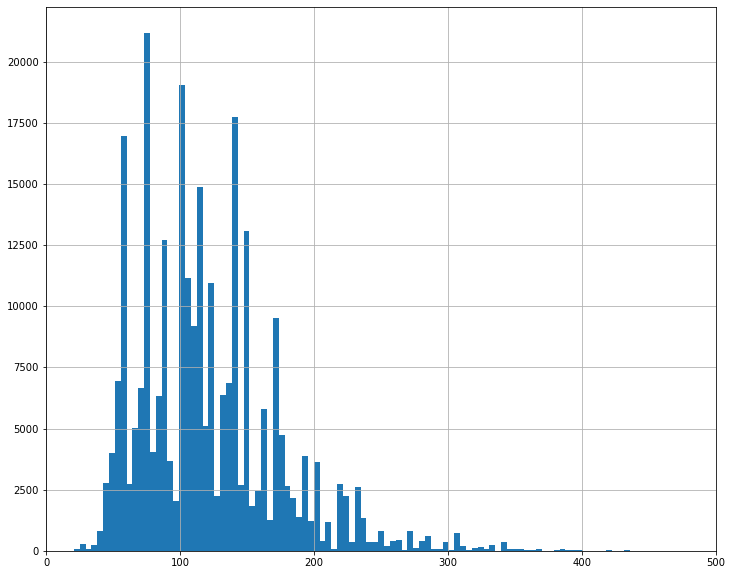

In [74]:
# просматриваю распределение
plt.figure(figsize=(12, 10))
features_lr['Power'].hist(bins=100)
plt.xlim(0, 500)

Имеем почти относительно нормальное распределение, попробуем сделать признак, который может дать нам нормальное распределение с помощью логарифмирования.

<AxesSubplot:>

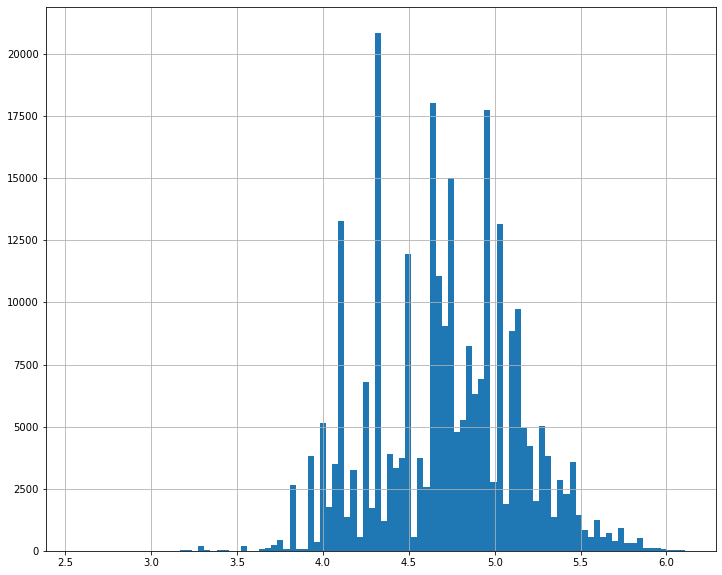

In [75]:
# просматриваю распределение
plt.figure(figsize=(12, 10))
np.log1p(features_lr['Power']).hist(bins=100)

Да, пойдет 

In [76]:
# делаю фичу с логарифмированными данными Power
features_lr['power_log'] = np.log1p(features_lr['Power'])

In [77]:
#  делю данные на трейн/тест для линейной регрессии
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(features_lr, target, test_size=0.2,
                                                                                        random_state=42)


features_train_test, features_test_test, target_train_test, target_test_test = train_test_split(features_lr_test, target_test, 
                                                                                                test_size=0.2, random_state=42)

In [89]:
# нормализация для основных выборок
numeric = ['Power', 'Kilometer', 'power_log']

scaler = StandardScaler()
standatd_scaler = scaler.fit(features_train_lr[numeric])
features_train_lr[numeric] = standatd_scaler.transform(features_train_lr[numeric])
features_test_lr[numeric] = standatd_scaler.transform(features_test_lr[numeric])

# нормализация для тестовых выборок
numeric_test = ['Power', 'Kilometer']

standatd_scaler_test = scaler.fit(features_train_test[numeric_test])
features_train_test[numeric_test] = standatd_scaler_test.transform(features_train_test[numeric_test])
features_test_test[numeric_test] = standatd_scaler_test.transform(features_test_test[numeric_test])


In [90]:
# линейная регрессия для предобработанных данных
lin_reg = LinearRegression(n_jobs=-1)

lin_reg.fit(features_train_lr, target_train_lr)
prediction = lin_reg.predict(features_test_lr)
print(mean_squared_error(target_test_lr, prediction, squared=False))

2364.6891927256916


Начало положено :) Линейная модель без подкруток выдаёт 2412 RMSE.(до исправления ошибок), с исправлением ошибок 2364

In [91]:
# линейная регрессия для не предобработанных данных
lin_reg = LinearRegression(n_jobs=-1)

lin_reg.fit(features_train_test, target_train_test)
prediction = lin_reg.predict(features_test_test)
print(mean_squared_error(target_test_test, prediction, squared=False))

2790.8455814529016


Отлично, хотя бы уже не зря делал предобработку

### Две выборки

Снизу работа над тем, чтобы разбить выборки на 2, премиальные/раритетные и обычные. 

In [92]:
premium = ['bmw', 'mecedes_benz', 'audi', 'mini', 'volvo', 'porshe', 'land_rover']
# функция для маркировки будущих выборок
def marking(df, list_brand=premium):
    year = df['RegistrationYear']
    price = df['Price']
    brand = df['Brand']
    if (year <= 1980 and price > 10000) or brand in list_brand:
        return 1
    return 0

In [93]:
df_test_two = df_test.copy()

In [94]:
df_test_two['Маркировка'] = df_test_two.apply(marking, axis=1)

In [95]:
premium = df_test_two[df_test_two['Маркировка'] == 1]
rare = df_test_two[df_test_two['Маркировка'] == 0]

In [135]:
# удаляю марки авто, которые встречаются меньше 5 раз
drop_premium = premium.Model.value_counts().tail(15).index
drop_rare = rare.Model.value_counts().tail(5).index

In [97]:

premium = premium.drop(premium.query('Model in @drop_premium').index)
rare = rare.drop(rare.query('Model in @drop_rare').index)

In [98]:
features_p = premium.drop(['Price', 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'Years',
                         'NumberOfPictures', 'PostalCode', 'LastSeen', 'Маркировка'], axis=1)
                       
target_p = premium['Price'] 

features_r = rare.drop(['Price', 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'Years',
                         'NumberOfPictures', 'PostalCode', 'LastSeen', 'Маркировка'], axis=1)
                       
target_r = rare['Price'] 

In [99]:
features_p['years'] = features_p.apply(years, start=1929, stop=2016, axis=1)
features_r['years'] = features_r.apply(years, start=1929, stop=2016, axis=1)

In [100]:
# удаляю столбец изначальный с годами, т.к. есть бинаризованный столбец с годами
features_p = features_p.drop(['RegistrationYear'], axis=1)
features_r = features_r.drop(['RegistrationYear'], axis=1)

In [101]:
# произвожу ohe с категориальными признаками
cat =['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'years']

ohe_p = OneHotEncoder(drop='first')
features_ohe_p = ohe_p.fit_transform(features_p[cat])

ohe_r = OneHotEncoder(drop='first')
features_ohe_r = ohe_r.fit_transform(features_r[cat])


# создаю датафрейм с преобработанными признаками
col_p = ohe_p.get_feature_names(cat)
features_ohe_p = pd.DataFrame(features_ohe_p.todense(), columns=col_p)

col_r = ohe_r.get_feature_names(cat)
features_ohe_r = pd.DataFrame(features_ohe_r.todense(), columns=col_r)


# обновляю индексы для того, чтобы проверсти join 
features_p = features_p.reset_index(drop=True)
features_normal_p = features_p[['Power', 'Kilometer']].join(features_ohe_p)

features_r = features_r.reset_index(drop=True)
features_normal_r = features_r[['Power', 'Kilometer']].join(features_ohe_r)

In [102]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(features_normal_p, target_p, test_size=0.2, random_state=42)

In [103]:
X_train_p.shape, X_test_p.shape

((48828, 102), (12207, 102))

In [104]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(features_normal_r, target_r, test_size=0.2, random_state=42)

In [105]:
X_train_r.shape, X_test_r.shape

((171236, 265), (42810, 265))

**Снизу ищу параметры для LightGBM**

In [212]:
seed=2

# список гиперпараметров и их значения
search_space = {
                'n_estimators':hp.uniform('n_estimators', 300, 1000),
                
                'max_depth':hp.uniform('max_depth', 20, 150),
                
                'num_leaves':hp.uniform('num_leaves', 31, 300)
                
    }

def objective(params, x, y):
    # переводим параметры в int
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    nl=int(params['num_leaves'])
    
    # задаём модели требуемые параметры    
    model=LGBMRegressor(n_estimators=est, max_depth=md, num_leaves = nl, reg_lambda = 0.01, min_split_gain=0.2)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=model, X=x, y=y, 
                            scoring='neg_root_mean_squared_error', cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, x=X_train_r, y=y_train_r),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=70,
          # куда сохранять историю поиска
            trials=trials,
          # random_state  
            rstate = np.random.default_rng(seed)
        )


print(best)

100%|██████████| 70/70 [22:24<00:00, 19.21s/trial, best loss: 1567.833400079527] 
{'max_depth': 69.11382982637943, 'n_estimators': 664.7795026848455, 'num_leaves': 150.14930983798294}


In [107]:
LGBM = LGBMRegressor(n_estimators=664, max_depth=69, num_leaves=150, reg_lambda = 0.01,
                     min_split_gain=0.2, n_jobs = -1, random_state=42)

LGBM.fit(X_train_r, y_train_r)
prediction = LGBM.predict(X_test_r)
print(mean_squared_error(y_test_r, prediction, squared=False))

1550.7182394113


Для обычных авто RMSE получилось 1550, прекрасно.

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Вывод <a class="tocSkip"> </h2>
Деление на выборки - неплохая практика, я думаю, как минимум, я понимаю, что удалив из выборки ещё какие-то строчки, то я могу получить ошибку намного меньше, чем есть на целом. 
    
Мне кажется, что я поделил выборки неправильно, нужно больше думать о том, как поделить их, тогда должно быть намного лушче.

## Леса

In [108]:
features_tree = features_normal.copy()

In [109]:
# рандомному лесу/lightGBM выдам с ohe и нормализацией
features_train_tree, features_test_tree, target_train_tree, target_test_tree = train_test_split(features_tree, target,
                                                                                                test_size=0.2, random_state=42)
# Catboost получит модель только с нормализацией 
features_train_cb, features_test_cb, target_train_cb, target_test_cb = train_test_split(features, target,
                                                                                                test_size=0.2, random_state=42)

### RandomForest(с признаком Model)

In [110]:
features_train_tree.head()

,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_unknow,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_UNK,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes,years_1939 - 1949,years_1949 - 1959,years_1959 - 1969,years_1969

In [111]:
features_train_tree.shape

(220098, 316)

In [112]:
forest = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=12, min_samples_split=10, n_jobs = -1,
                               min_samples_leaf=2, random_state=42)

forest.fit(features_train_tree, target_train_tree)

RandomForestRegressor(criterion='mse', max_depth=12, min_samples_leaf=2,
                      min_samples_split=10, n_estimators=50, n_jobs=-1,
                      random_state=42)

In [113]:
prediction = forest.predict(features_test_tree)
print(mean_squared_error(target_test_tree, prediction, squared=False))

2014.6033668238244


Леса выглядят намного лучше, с учутом того, что я не пытался подобрать какие-то параметры для улучшения. Этим я и займусь

Если посмотреть на важность признаков, получается, что признак Model для некоторых марок важен, а для некоторых нет.


### RandomForest(без признака Model)

In [114]:
features

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,years
0,coupe,manual,190,UNK,125000,gasoline,audi,yes,2009 - 2017
1,suv,auto,163,grand,125000,gasoline,jeep,UNK,1999 - 2009
2,small,manual,75,golf,150000,petrol,volkswagen,no,1999 - 2009
3,small,manual,69,fabia,90000,gasoline,skoda,no,1999 - 2009
4,sedan,manual,102,3er,150000,petrol,bmw,yes,1989 - 1999
...,...,...,...,...,...,...,...,...,...
275118,sedan,manual,140,golf,150000,gasoline,volkswagen,no,2009 - 2017
275119,sedan,manual,225,leon,150000,petrol,seat,yes,1999 - 2009
275120,convertible,auto,101,fortwo,125000,petrol,smart,no,1999 - 2009
275121,bus,manual,102,transporter,150000,gasoline,volkswagen,no,1989 - 1999


In [115]:
features_no_model = features.copy()
features_no_model = features_no_model.drop('Model', axis=1)

In [117]:
# произвожу ohe с категориальными признаками
cat_two =['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired', 'years']

ohe = OneHotEncoder(drop='first')
features_no_model = ohe.fit_transform(features_no_model[cat_two])

col_two = ohe.get_feature_names(cat_two)

features_no_model = pd.DataFrame(features_no_model.todense(), columns=col_two)
# tree_ohe_rf_test_two = pd.DataFrame(tree_ohe_rf_test_two.todense(), columns=col_two)

In [118]:
 

# соединяю воедино ohe признаки с числовыми
features_no_model_normal = features[['Power', 'Kilometer']].join(features_no_model)
# features_tree_test_normal_two =  features_test_tree_two[['Power', 'Kilometer']].join(tree_ohe_rf_test_two)

In [120]:
features_train_tree_no_model, features_test_tree_no_model, target_train_tree_no_model, target_test_tree_no_model = train_test_split(
    features_no_model_normal, target,
    test_size=0.2, random_state=42)

In [121]:
# обучаю модель с рандомными параметрами, чтобы понять, сколько могут выдавать леса
forest = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=12, min_samples_split=10, n_jobs = -1,
                               min_samples_leaf=2, random_state=42)

forest.fit(features_train_tree_no_model, target_train_tree_no_model)
prediction = forest.predict(features_test_tree_no_model)
print(mean_squared_error(target_test_tree_no_model, prediction, squared=False))

2025.5551756779905


**Вывод по Model**

Без признака моделей хуже, но не сильно, не забываем, что лучше параметры не найдены, а также не забывает про минимизацию ошибки с помощью градиентного бустинга, который может разницу сделать побольше, как мне кажется

# Обучение моделей

### Нахождение лучших параметров для RandomForest

In [146]:
seed=2

# список гиперпараметров и их значения
search_space = {
                'n_estimators':hp.uniform('n_estimators', 1, 70),
                
                'max_depth':hp.uniform('max_depth', 1, 50),
                
                'min_samples_leaf':hp.uniform('min_samples_leaf', 1, 5),
                
                'min_samples_split':hp.uniform('min_samples_split', 2 , 10)
                
    }

def objective(params, x, y):
    # переводим параметры в int
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    msl=int(params['min_samples_leaf'])
    mss=int(params['min_samples_split'])
    
    # задаём модели требуемые параметры    
    model=RandomForestRegressor(n_estimators=est,max_depth=md,min_samples_leaf=msl,min_samples_split=mss)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=model, X=x, y=y, 
                            scoring='neg_root_mean_squared_error', cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, x=features_train_tree, y=target_train_tree),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=25,
          # куда сохранять историю поиска
            trials=trials,
          # random_state  
            rstate = np.random.default_rng(seed)
        )


100%|██████████| 25/25 [59:32<00:00, 142.90s/trial, best loss: 1767.791190548557]  


In [147]:
print(best)

{'max_depth': 48.54234241967807, 'min_samples_leaf': 2.8640317322880113, 'min_samples_split': 6.0517446206582335, 'n_estimators': 69.01273009541234}


In [122]:
%%timeit
# обучаю модель и смотрю время предсказания
forest_two = RandomForestRegressor(n_estimators=69, criterion='mse', max_depth=48,
                               min_samples_split=6, n_jobs = -1,
                               min_samples_leaf=2, random_state=42)

forest_two.fit(features_train_tree, target_train_tree)

1min 11s ± 748 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [123]:
forest_two = RandomForestRegressor(n_estimators=69, criterion='mse', max_depth=48,
                               min_samples_split=6, n_jobs = -1,
                               min_samples_leaf=2, random_state=42)

forest_two.fit(features_train_tree, target_train_tree)

RandomForestRegressor(criterion='mse', max_depth=48, min_samples_leaf=2,
                      min_samples_split=6, n_estimators=69, n_jobs=-1,
                      random_state=42)

In [124]:
%%timeit
prediction = forest_two.predict(features_test_tree)

342 ms ± 8.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [125]:
prediction = forest_two.predict(features_test_tree)
print(mean_squared_error(target_test_tree, prediction, squared=False))

1744.039476787586


In [126]:
skf = StratifiedKFold(n_splits=4, shuffle=True)
score = cross_val_score(estimator=forest_two, X=features_train_tree, y=target_train_tree, 
                        scoring='neg_root_mean_squared_error', cv=skf, n_jobs=-1)

In [127]:
# просматриваю score по кросс-валидации
-score.mean() 

1768.5329802993172

После оптимизации параметров RMSE равна 1744, неплохо, кросс-валидация - 1768

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> RandomForest <a class="tocSkip"> </h2>
Результаты: обучение - 1min 10s, лучшее качество - 1744, время предсказания - 342 ms

### LightGBM

Параметры, которые я хочу оптимизировать: num_leaves, max_depth, n_estimators

In [156]:
seed=2

# список гиперпараметров и их значения
search_space = {
                'n_estimators':hp.uniform('n_estimators', 300, 1000),
                
                'max_depth':hp.uniform('max_depth', 20, 150),
                
                'num_leaves':hp.uniform('num_leaves', 31, 300)
                
    }

def objective(params, x, y):
    # переводим параметры в int
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    nl=int(params['num_leaves'])
    
    # задаём модели требуемые параметры    
    model=LGBMRegressor(n_estimators=est, max_depth=md, num_leaves = nl, reg_lambda = 0.01, min_split_gain=0.2)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=model, X=x, y=y, 
                            scoring='neg_root_mean_squared_error', cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, x=features_train_tree, y=target_train_tree),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=100,
          # куда сохранять историю поиска
            trials=trials,
          # random_state  
            rstate = np.random.default_rng(seed)
        )

100%|██████████| 100/100 [47:52<00:00, 28.73s/trial, best loss: 1715.7809679581758]


In [157]:
print(best)

{'max_depth': 118.40030032597144, 'n_estimators': 823.8885913598409, 'num_leaves': 181.397150169081}


In [128]:
%%timeit
# обучаю lightgbm 
LGBM = LGBMRegressor(n_estimators=823, max_depth=118, num_leaves=181, reg_lambda = 0.01,
                     min_split_gain=0.2, n_jobs = -1, random_state=42)

LGBM.fit(features_train_tree, target_train_tree)

9.07 s ± 352 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


c %%time не обучается, а считает время, из-за этого в коментах, но ниже результаты описаны

In [129]:
LGBM = LGBMRegressor(n_estimators=823, max_depth=118, num_leaves=181, reg_lambda = 0.01,
                     min_split_gain=0.2, n_jobs = -1, random_state=42)

LGBM.fit(features_train_tree, target_train_tree)

LGBMRegressor(max_depth=118, min_split_gain=0.2, n_estimators=823,
              num_leaves=181, random_state=42, reg_lambda=0.01)

In [130]:
%%timeit
prediction = LGBM.predict(features_train_tree)

4.09 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [131]:
prediction = LGBM.predict(features_test_tree)
print(mean_squared_error(target_test_tree, prediction, squared=False))

1693.4023380269387


LightGBM выдает RMSE 1693, неплохо, лучше RandomForest


In [124]:
features_test_tree.head()

,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_unknow,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_UNK,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes,years_1939 - 1949,years_1949 - 1959,years_1959 - 1969,years_1969

**SHAP**

In [125]:
shap_values = shap.TreeExplainer(LGBM, features_test_tree).shap_values(features_test_tree)

100%|===================| 55015/55025 [47:02<00:00]        

In [128]:
features_test_tree.shape

(55025, 316)

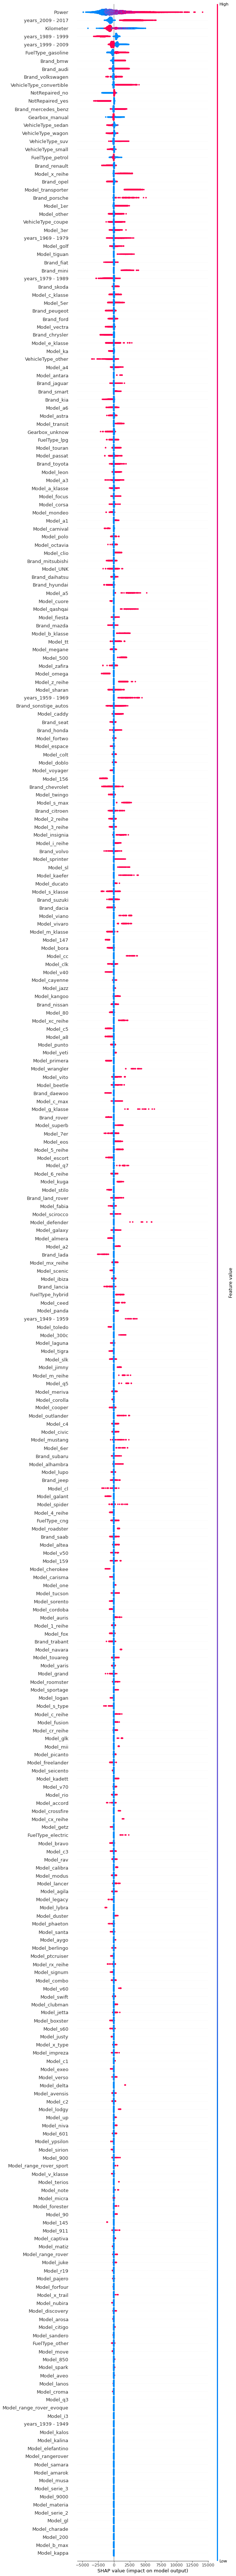

In [130]:
shap.summary_plot(shap_values, features_test_tree, max_display=316)

По мощности авто понятно, что чем больше мощность, тем больше будет стоить автомобиль, также дисперия хорошая, этот признак важен. Пробег: чем меньше пробег, тем также повышается цена, но есть не которые случаи, где это наоборот(предполагаю из-за тех выбросов - раритетов, которые я оставил)


Также показаны авто, которые повышают цену(bmw, audi, mercedes_benz, porshe, mini, skoda слегка, jaguar, toyota) - самые популярные, также описаны марки, которые понижают цену(renault, opel, fiat, peugeot, ford, chrysler) - одни из. Также показано, что машины старых годов понижают цену, что странно, а таже странно, что chrysler, которая имела много сил, понижает цену.


Интересные выводы можно сделать, один из них - нужно намного тщателнее предобрабатывать, т.к. shap показывает, что все еще есть какие-то "неровности", которые можно было бы убрать.

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> LightGBM <a class="tocSkip"> </h2>
Результаты: обучение - 8.47 s, лучшее качество - 1693, время предсказания - 4.08 s

### Catboost

In [132]:
features_train_cb

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,years
199120,other,manual,163,other,150000,gasoline,volkswagen,no,2009 - 2017
179057,bus,manual,105,transporter,150000,UNK,volkswagen,no,1999 - 2009
98008,small,auto,60,up,30000,petrol,volkswagen,no,2009 - 2017
123709,coupe,auto,250,a3,125000,petrol,audi,no,1999 - 2009
201391,small,manual,65,other,40000,petrol,fiat,no,1999 - 2009
...,...,...,...,...,...,...,...,...,...
119879,small,manual,58,other,90000,petrol,hyundai,no,1999 - 2009
259178,bus,manual,110,other,150000,petrol,mitsubishi,yes,1999 - 2009
131932,sedan,manual,88,3_reihe,150000,petrol,mazda,no,1989 - 1999
146867,small,manual,182,fiesta,10000,petrol,ford,no,2009 - 2017


In [133]:
# параметры для Catboost
CB = CatBoostRegressor(
    iterations=8000,
    learning_rate=0.1,
    random_seed=42,
    use_best_model=True,
    l2_leaf_reg = 0.1)

In [108]:
%%time
# обучаю Catboost и смотрю время обучения
CB.fit(
    features_train_cb, target_train_cb,
    eval_set=(features_test_cb, target_test_cb),
    verbose=False,
    plot=True,
    cat_features=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'years']
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 23min 26s


In [109]:
%%timeit
prediction = CB.predict(features_test_cb)

805 ms ± 68.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Catboost<a class="tocSkip"> </h2>
Результаты: обучение - 25 минут, лучшее качество - 1727, время предсказания - 845 ms

In [110]:
# просматриваю лучший score
CB.best_score_

{'learn': {'RMSE': 1525.5815697742928},
 'validation': {'RMSE': 1727.132720151199}}

In [111]:
# смотрю какие из признаков важные
pd.Series(CB.feature_importances_, index=features_train_cb.columns).sort_values(ascending=False)

Power          30.966730
years          25.586521
Kilometer      11.064205
Brand           8.872078
Model           7.819934
VehicleType     6.042886
FuelType        5.254757
NotRepaired     3.176414
Gearbox         1.216475
dtype: float64

<AxesSubplot:>

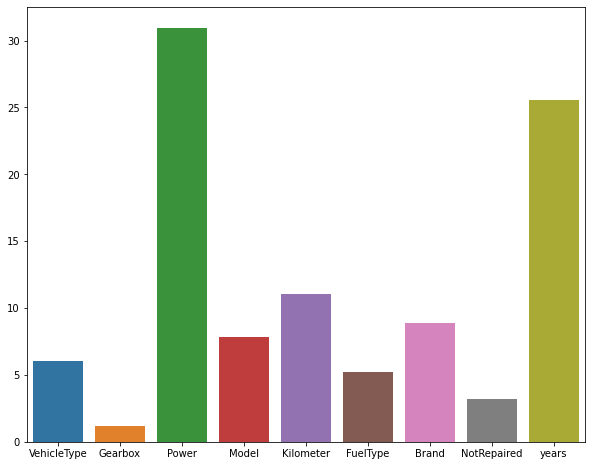

In [112]:
# график важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(features_train_cb.columns, CB.feature_importances_)

Catboost показывает, что Power очень информативно, также как и года.
Результат - 1760.

# Анализ моделей

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Вывод<a class="tocSkip"> </h2>
    На данный момент LightGBM выдает самые лучшие результаты
    Результаты: 
    
    Catboost: обучение - 25 минут, лучшее качество - 1727, время предсказания - 845 ms
    
    LGBM: обучение - 8.47 s, лучшее качество - 1693, время предсказания - 4.08 s
    
    RandomForest: обучение - 1min 10s, лучшее качество - 1744, время предсказания - 342 ms

In [134]:
fit = [8.47, 1500, 70]
score = [1693, 1727, 1744]
predict = [4.08, 0.845, 0.342]

pd.DataFrame([fit, score, predict], 
             index=['Обучение/с', 'Качество', 'Предсказание/с'],
             columns=['LGMB', 'Catboost', 'RandomForest'])

,LGMB,Catboost,RandomForest
Обучение/с,8.47,1500.000,70.000
Качество,1693.00,1727.000,1744.000
Предсказание/с,4.08,0.845,0.342
